In [204]:
import gc, time
#import datatable as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gc
import seaborn as sns
import scipy
import sklearn
import lightgbm as lgb
from tqdm.notebook import tqdm
from sklearn.metrics import log_loss, mean_squared_error
from sklearn.model_selection import train_test_split
from scipy.stats import spearmanr
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
import copy
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import KFold
import re
from sklearn import linear_model
import math
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_classification
from sklearn.preprocessing import PolynomialFeatures
from scipy import stats
from sklearn.metrics import confusion_matrix
import seaborn as sn
from patsy import dmatrices
import numpy as np
import re
import warnings
from sklearn import preprocessing

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.core.common.SettingWithCopyWarning)
    
plt.style.use('bmh')
plt.rcParams['figure.figsize'] = [14, 8]  # width, height


## Data processing from text file to csv

In [10]:
def getlines(path):
    file = open(path, 'r')

    Lines = file.readlines() 
    Lines2 = []
    for line in Lines:
        line = line.strip()
        if line != "":
            Lines2.append(line)
    return Lines2

In [76]:
def raw_to_df(trainraw):
    trainraw[0].split(";")
    traindict = {}
    for i in trainraw[0].split(";"):
        if re.findall("\".*\"", i.split(",")[0]):
            col_name = i.split(",")[0].replace('"', '')
            traindict[col_name] = []
    for j in range(1,len(trainraw)):
        for ik,k in enumerate(trainraw[j].split(";")):
            if re.findall("\".*\"",k):
                value = k.split(",")[0].replace('"', '')
                traindict[list(traindict.keys())[ik]].append(value)
            else:
                traindict[list(traindict.keys())[ik]].append(k)
    train_df = pd.DataFrame(traindict)
    return train_df    

In [14]:
trainraw = getlines('/etlstage/DSPEE_Collaboration/jtlau/test/traininingdata.txt')
testraw = getlines('/etlstage/DSPEE_Collaboration/jtlau/test/testdata.txt')

In [107]:
train_df = raw_to_df(trainraw)
test_df = raw_to_df(testraw)

In [108]:
train_df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,42,technician,divorced,secondary,no,-78,yes,yes,cellular,29,jul,10,23,-1,0,unknown,no
1,50,management,married,tertiary,no,106,yes,no,unknown,15,may,388,2,-1,0,unknown,no
2,47,admin.,married,secondary,no,407,yes,no,unknown,5,jun,67,12,-1,0,unknown,no
3,39,admin.,divorced,secondary,no,952,yes,no,unknown,16,jun,62,1,-1,0,unknown,no
4,30,management,single,tertiary,no,364,no,no,cellular,30,apr,306,2,-1,0,unknown,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36163,30,management,single,tertiary,no,1243,yes,no,telephone,13,nov,86,1,174,1,failure,no
36164,60,blue-collar,married,secondary,no,171,yes,no,unknown,19,may,219,2,-1,0,unknown,no
36165,41,technician,married,secondary,no,-274,yes,no,unknown,27,may,182,3,-1,0,unknown,no
36166,45,blue-collar,married,primary,no,103,no,no,cellular,28,jan,64,3,-1,0,unknown,no


In [198]:
train_df['poutcome'].describe()

count       36168
unique          4
top       unknown
freq        29623
Name: poutcome, dtype: object

In [110]:
train_df[['age','balance','day','duration','campaign','pdays','previous']] = train_df[['age','balance','day','duration','campaign','pdays','previous']].astype(int)
test_df[['age','balance','day','duration','campaign','pdays','previous']] = test_df[['age','balance','day','duration','campaign','pdays','previous']].astype(int)

## Data cleansing/ exploration

In [96]:
def checknull(train_df,column):
    count = train_df.loc[train_df[column].isna() == True][column].count()
    print('{} : {} nulls'.format(column,count))

In [97]:
for col in train_df.columns.tolist():
    checknull(train_df, col)

age : 0 nulls
job : 0 nulls
marital : 0 nulls
education : 0 nulls
default : 0 nulls
balance : 0 nulls
housing : 0 nulls
loan : 0 nulls
contact : 0 nulls
day : 0 nulls
month : 0 nulls
duration : 0 nulls
campaign : 0 nulls
pdays : 0 nulls
previous : 0 nulls
poutcome : 0 nulls
y : 0 nulls


In [120]:
def plot_hist(train_df,column):
    collist = train_df[column]
    plt.figure(figsize=(5, 5))
    plt.hist(collist, density = False)

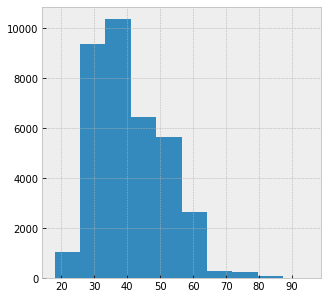

In [121]:
plot_hist(train_df,'age')

In [184]:
def splithist(train_df, column1, column2):
    col2list = train_df[column2]
    col1list = train_df[column1]
    df_col1_col2 = pd.DataFrame({"col1":col1list, "col2":col2list})
    df_col1_col2 =  df_col1_col2.dropna(axis=0)
    splithisto =  df_col1_col2['col1'].hist(by= df_col1_col2['col2'],figsize=(10,10), density=False)


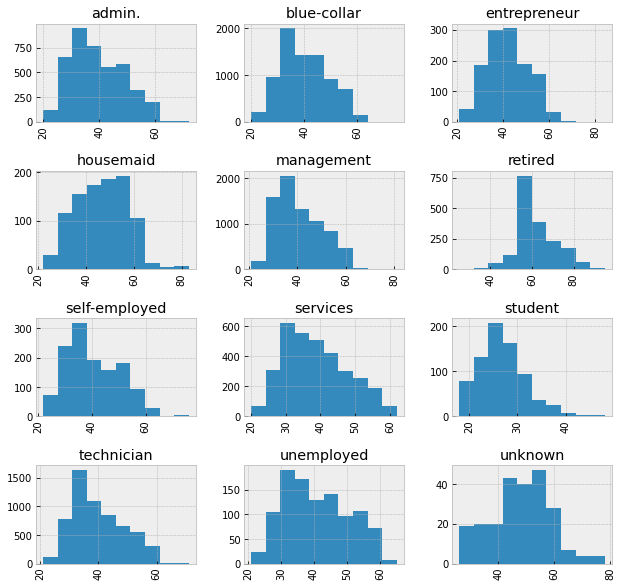

In [185]:
splithist(train_df, 'age', 'job')

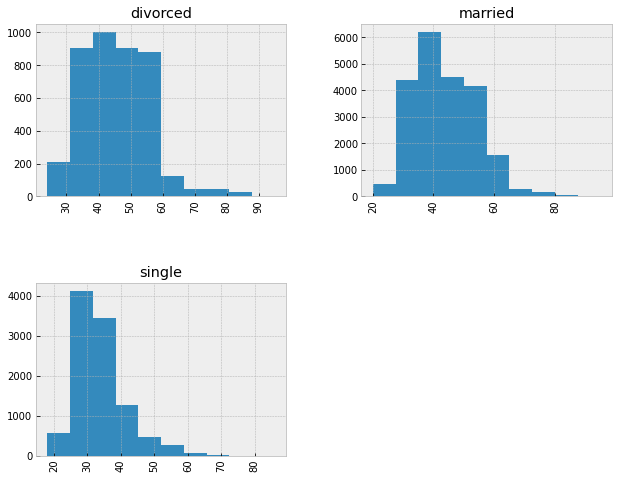

In [131]:
splithist(train_df, 'age', 'marital')

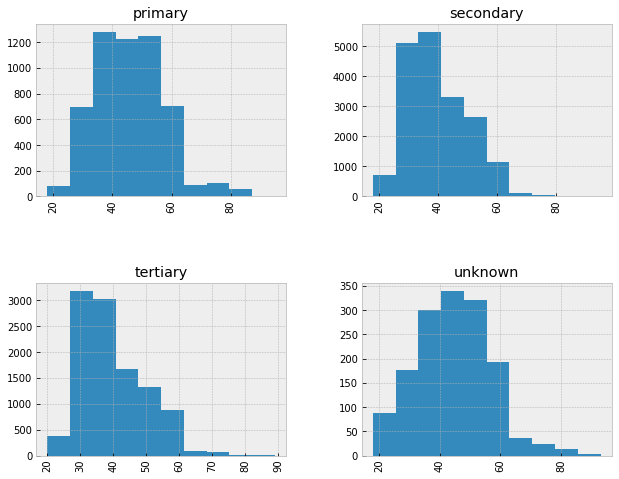

In [132]:
splithist(train_df, 'age', 'education')

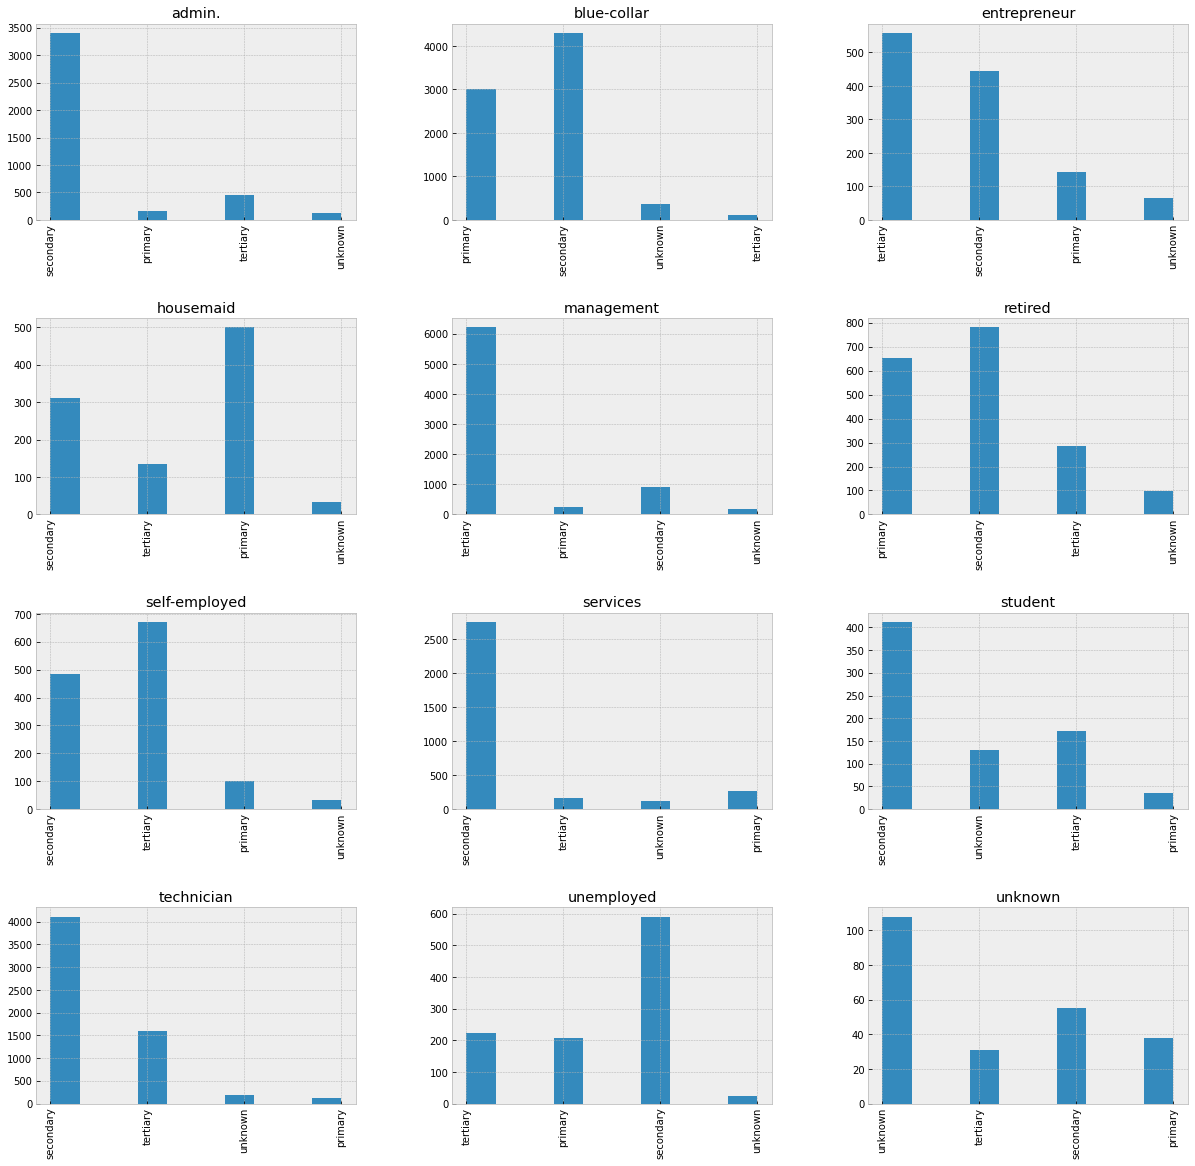

In [145]:
splithist(train_df, 'education', 'job')

## Imputing education data based on job
    admin. -> secondary
    management -> tertiary
    services -> secondary
    blue-collar -> primary, secondary
    housemaid -> primary, secondary
    self-employed -> secondary, tertiary
    technician -> secondary, tertiary
    entrepreneur -> secondary, tertiary


not clear: retired, student, unemployed, unknown

In [147]:
train_df.loc[(train_df['job'] == 'admin.')&(train_df['education'] == 'unknown'), 'education'] = 'secondary'

In [150]:
train_df.loc[(train_df['job'] == 'management')&(train_df['education'] == 'unknown'), 'education'] = 'tertiary'

In [153]:
train_df.loc[(train_df['job'] == 'services')&(train_df['education'] == 'unknown'),'education' ] = 'secondary'

### For education that can be bin into more than 1 class, to look at other factors
    blue-collar -> primary, secondary
    housemaid -> primary, secondary
    self-employed -> secondary, tertiary
    technician -> secondary, tertiary
    entrepreneur -> secondary, tertiary

use housing, loan,default, age, balance, marital, contact

housing
loan
default
age
balance
marital
contact


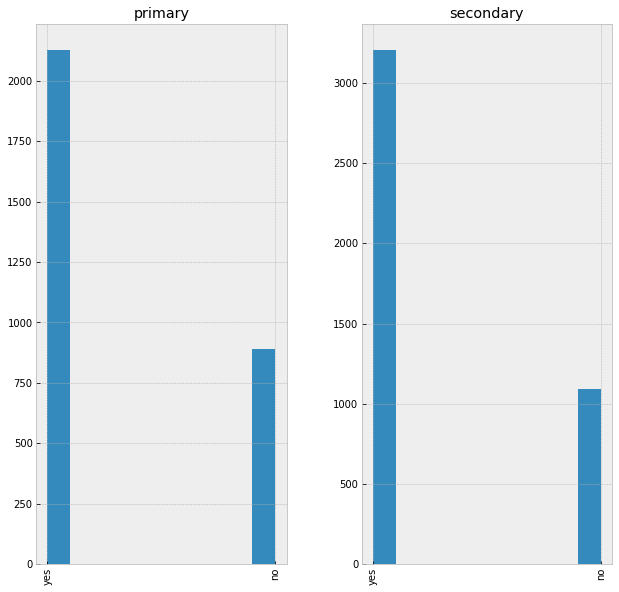

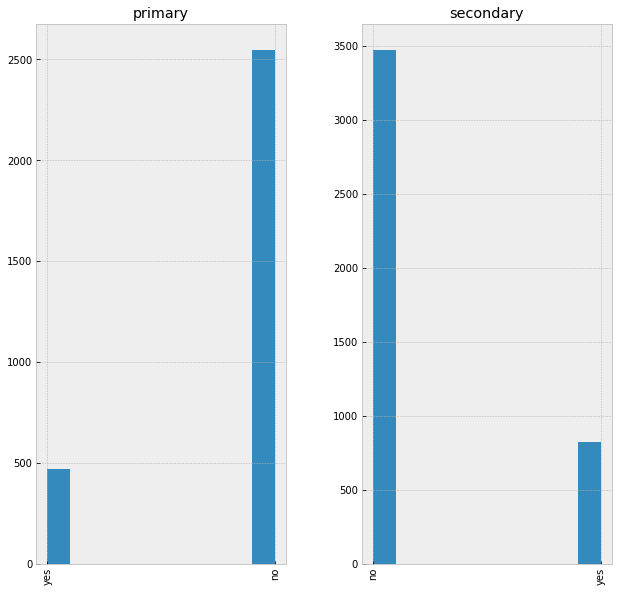

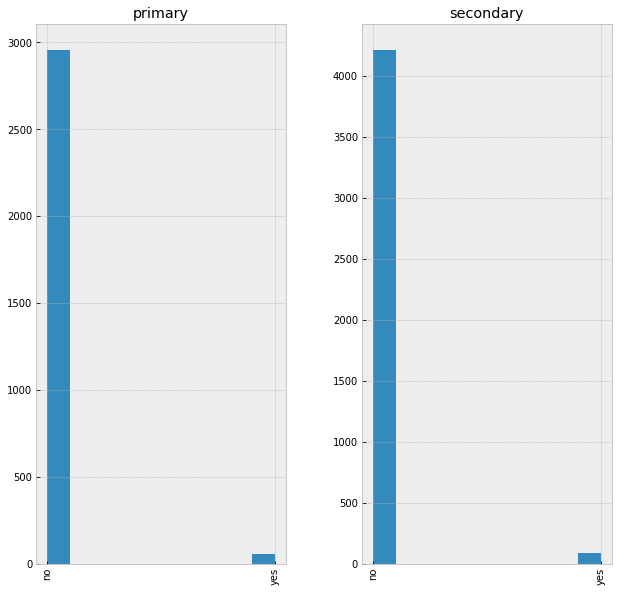

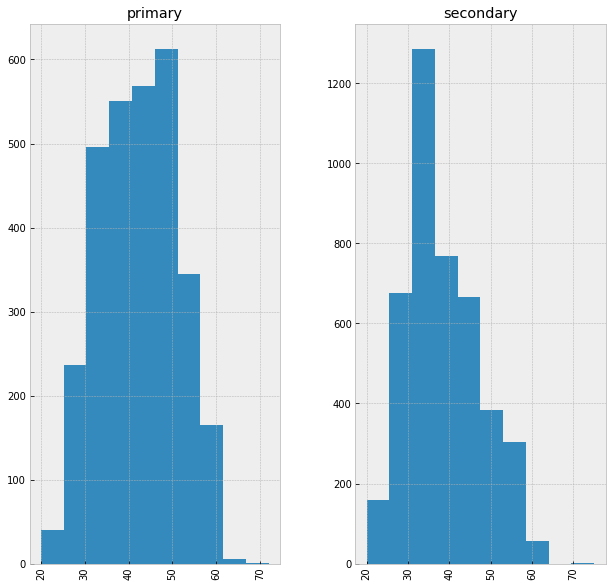

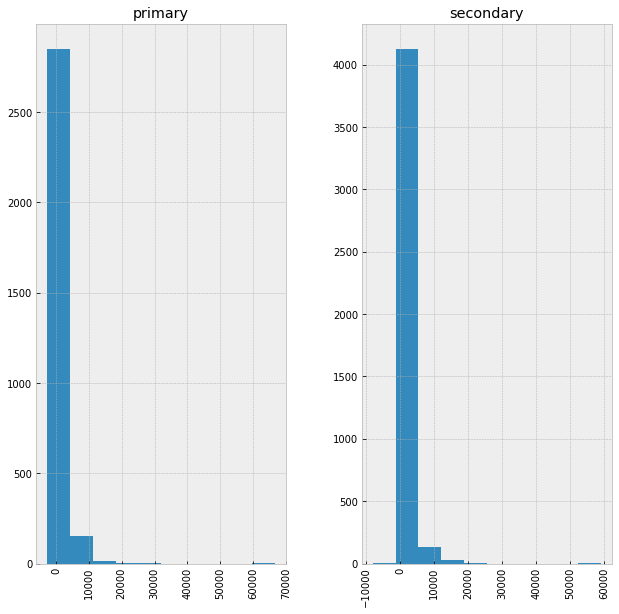

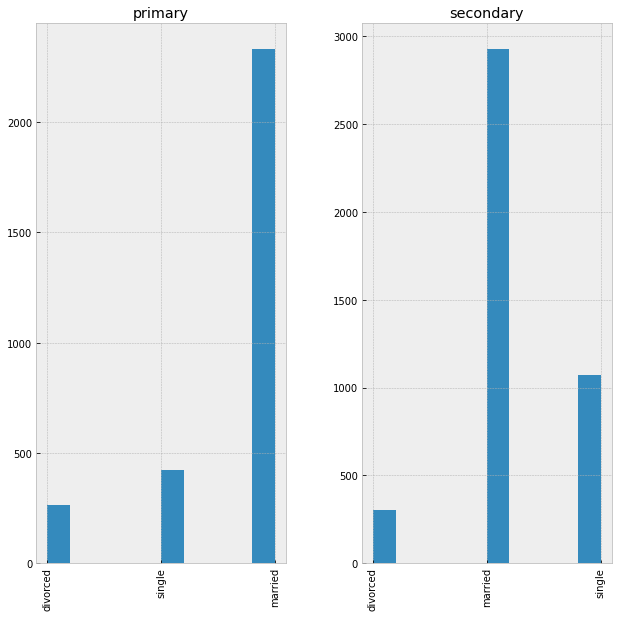

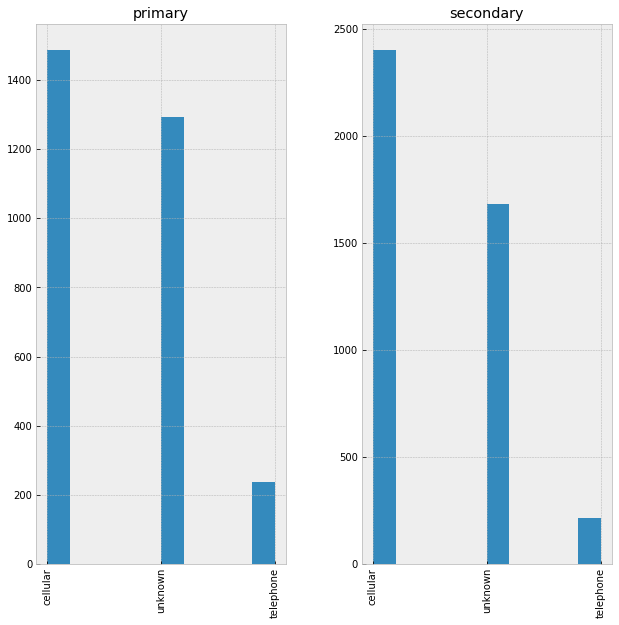

In [199]:
listcheck = ['housing', 'loan','default', 'age', 'balance', 'marital', 'contact']
df_bluecollar = train_df.loc[(train_df['job'] == 'blue-collar')&((train_df['education'] == 'secondary')|(train_df['education'] == 'primary'))].copy()
for check in listcheck:
    splithist(df_bluecollar, check, 'education')
    print(check)

housing
loan
default
age
balance
marital
contact


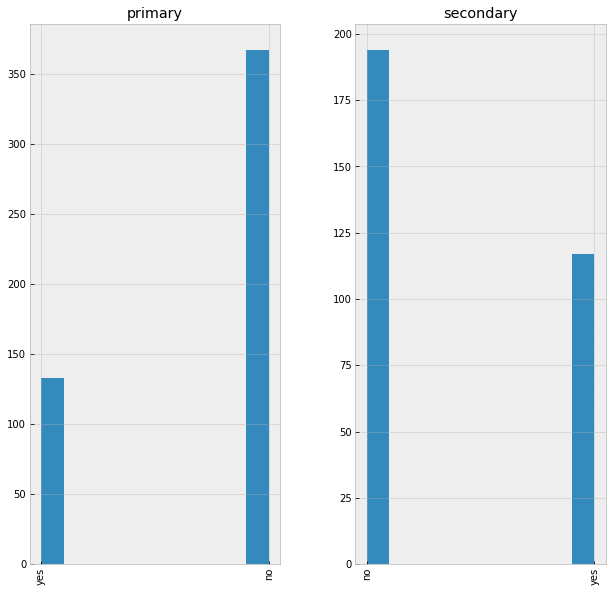

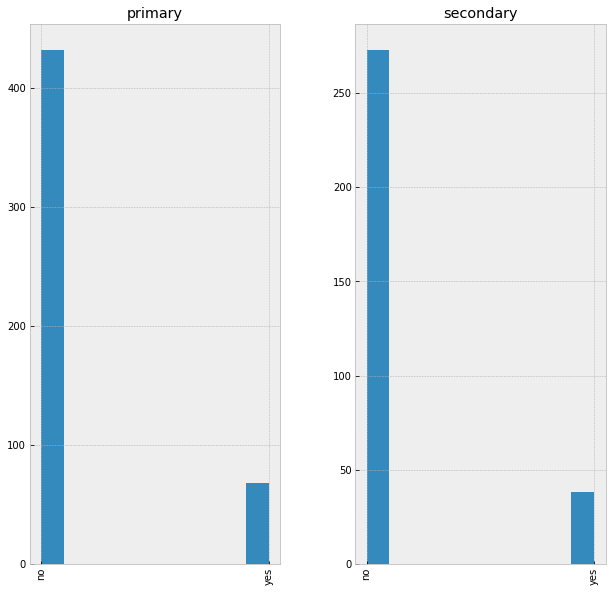

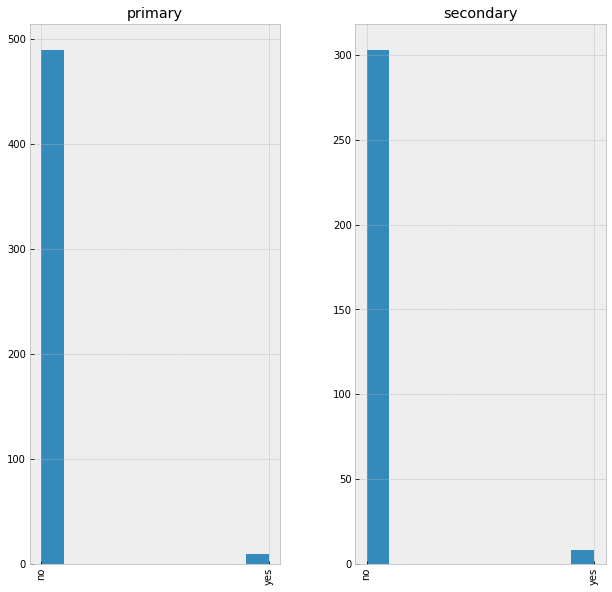

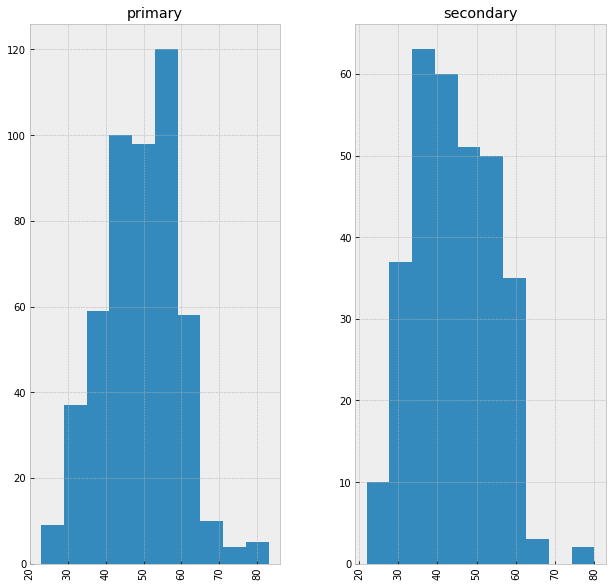

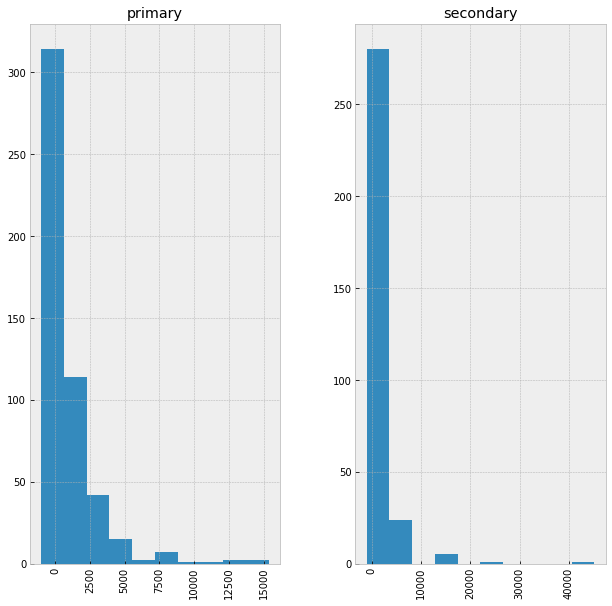

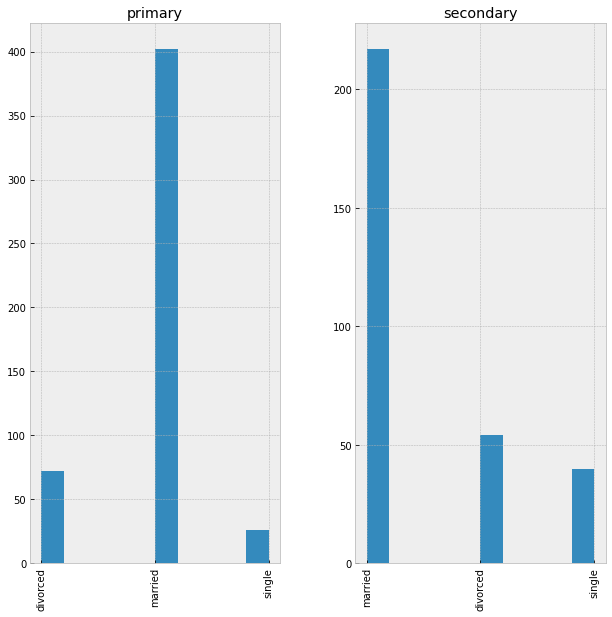

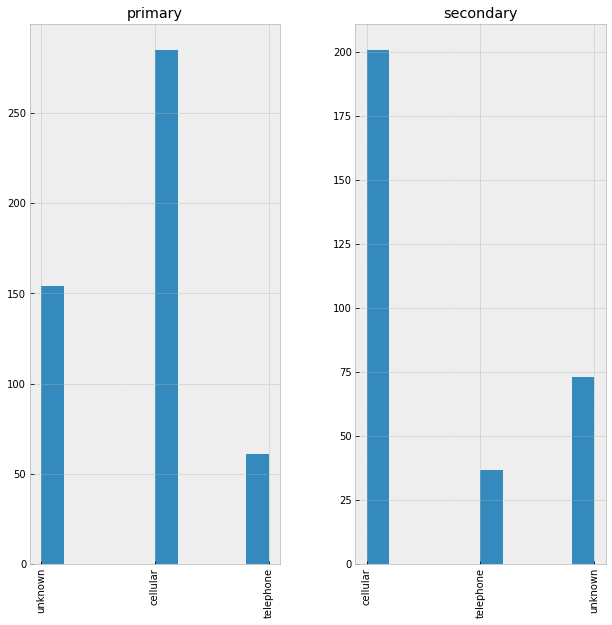

In [200]:
df_housemaid = train_df.loc[(train_df['job'] == 'housemaid')&((train_df['education'] == 'secondary')|(train_df['education'] == 'primary'))].copy()
for check in listcheck:
    splithist(df_housemaid, check, 'education')
    print(check)

housing
loan
default
age
balance
marital
contact


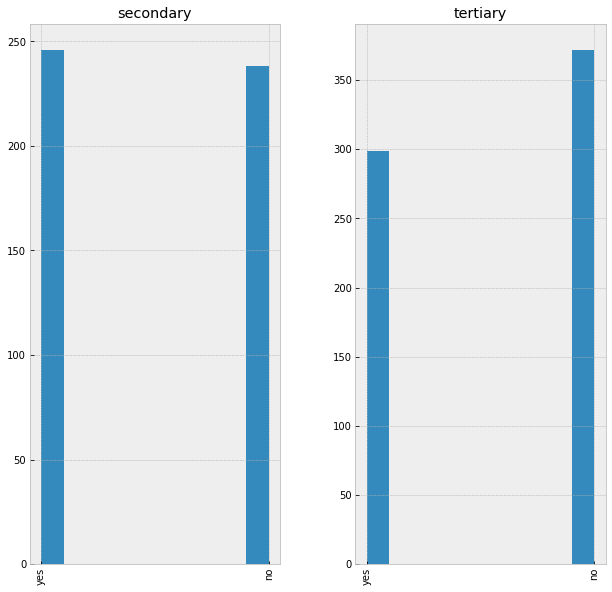

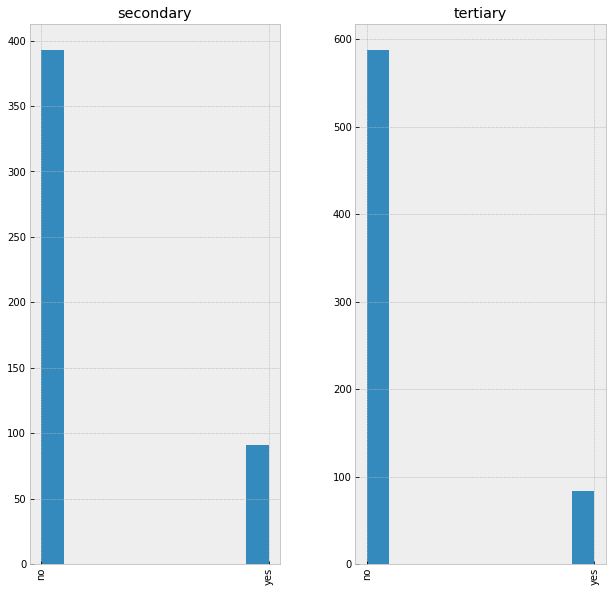

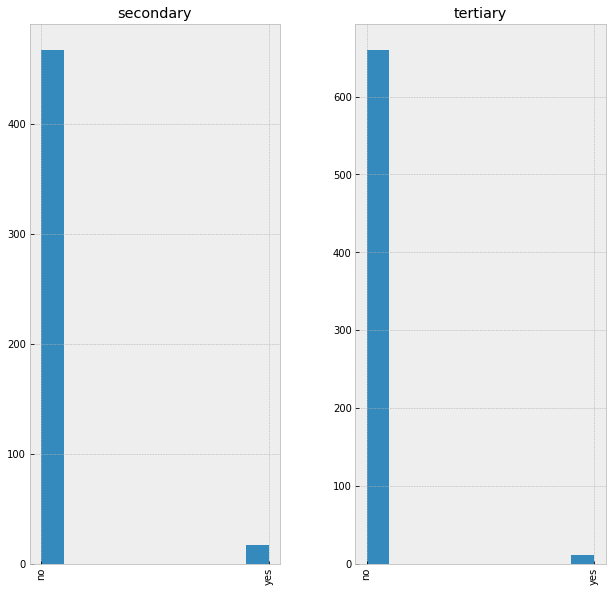

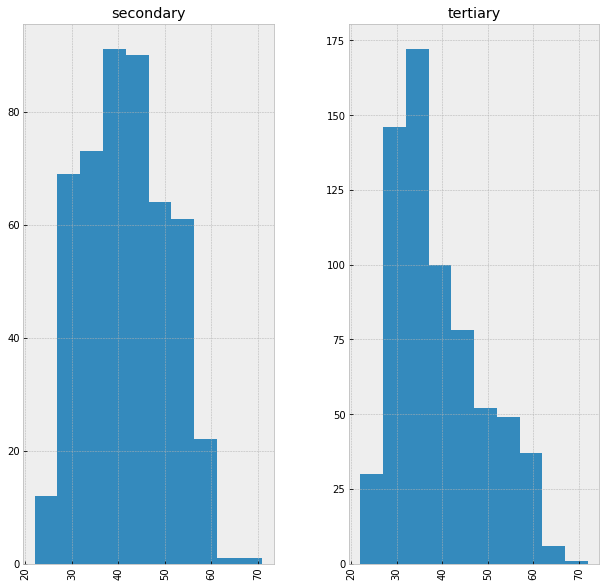

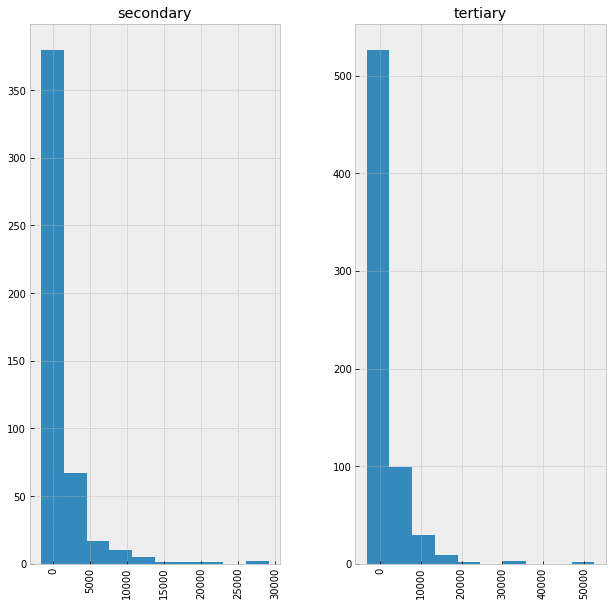

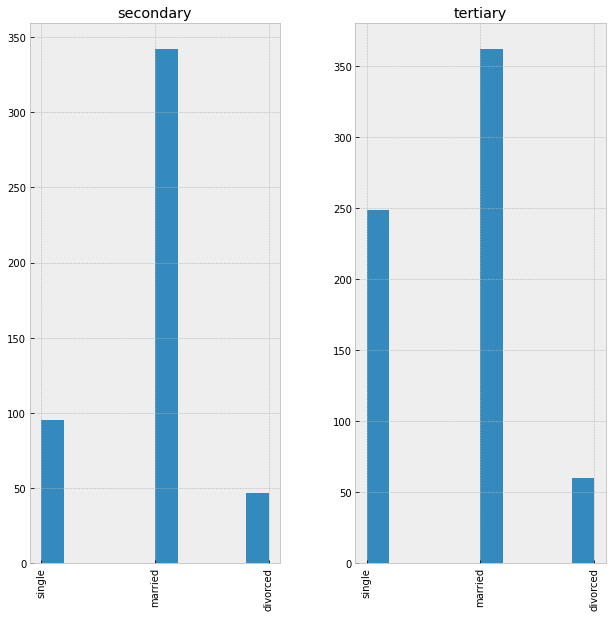

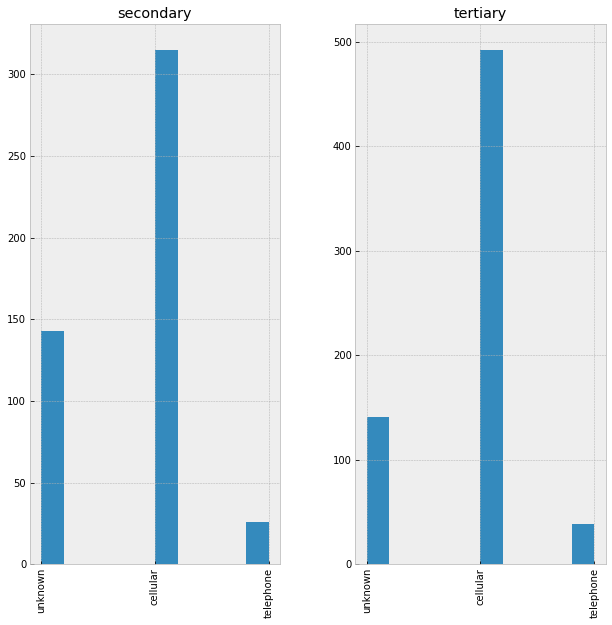

In [201]:
df_self_employed = train_df.loc[(train_df['job'] == 'self-employed')&((train_df['education'] == 'secondary')|(train_df['education'] == 'tertiary'))].copy()
for check in listcheck:
    splithist(df_self_employed, check, 'education')
    print(check)

housing
loan
default
age
balance
marital
contact


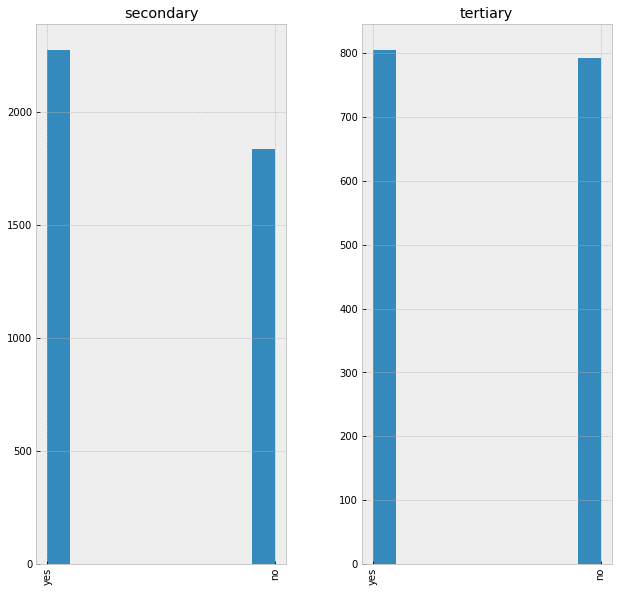

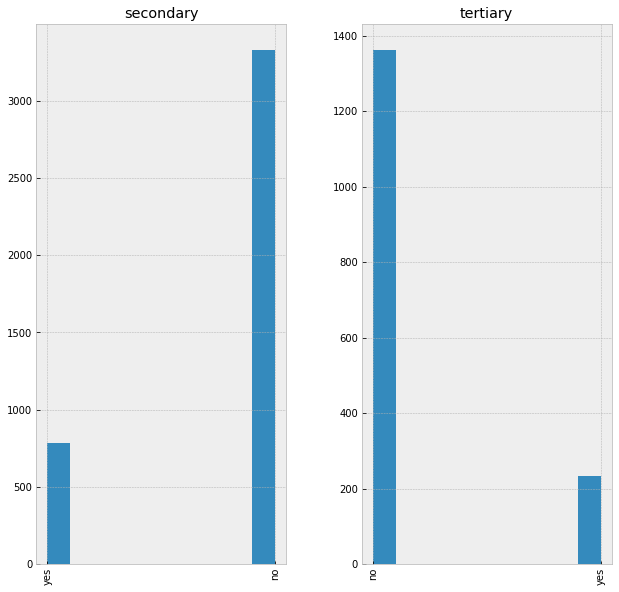

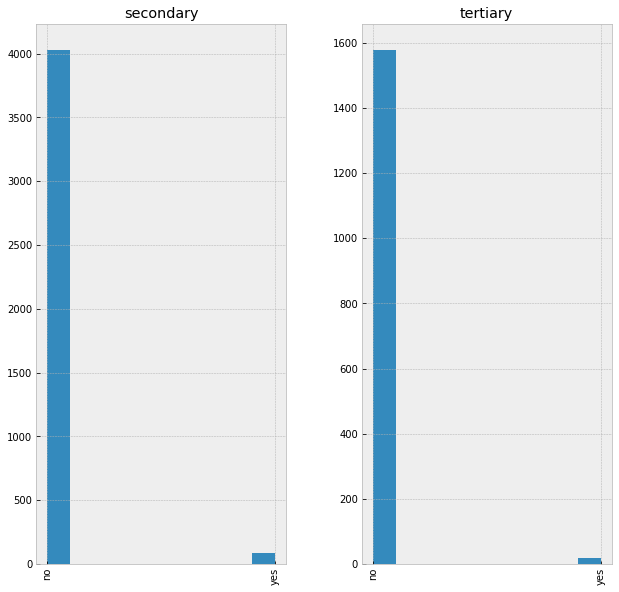

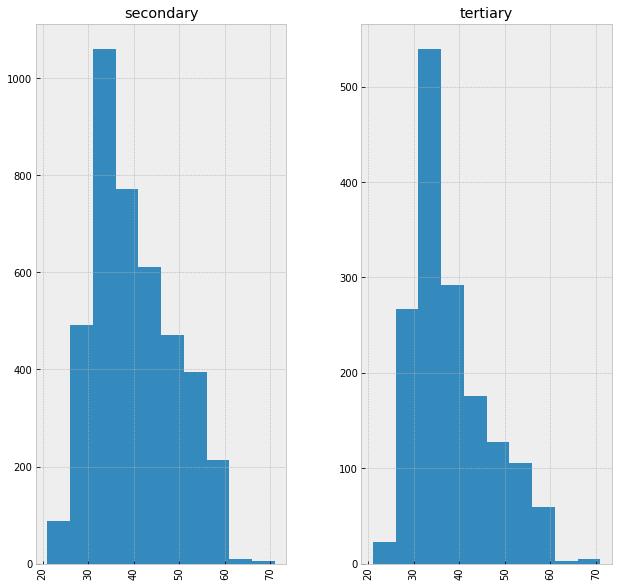

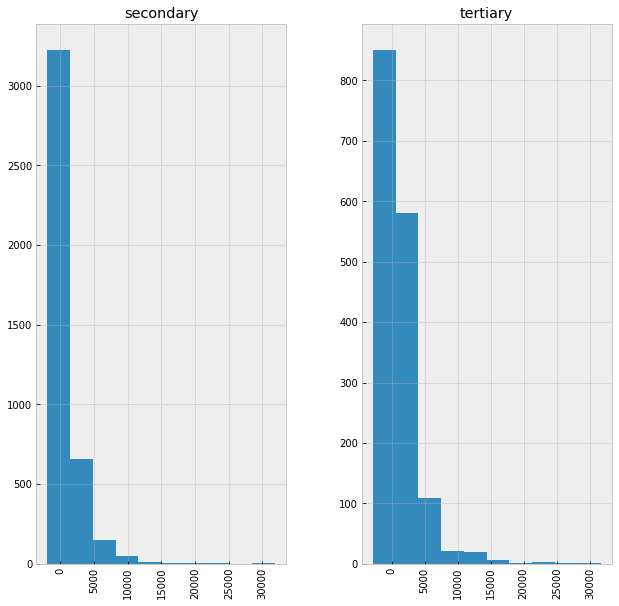

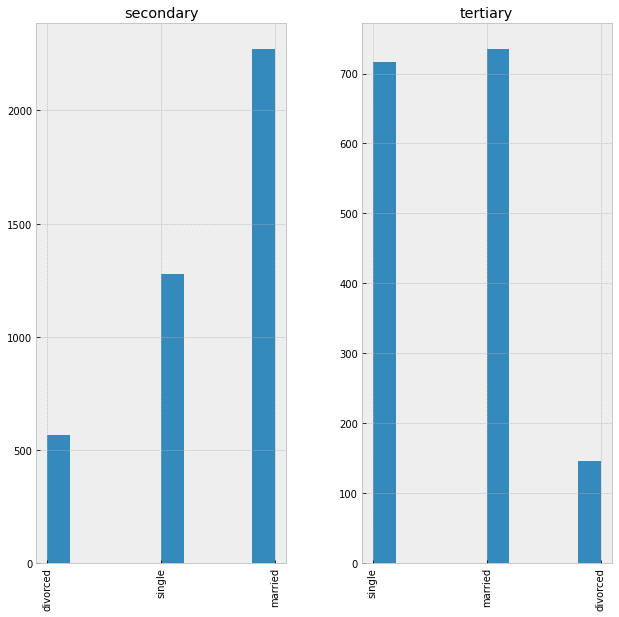

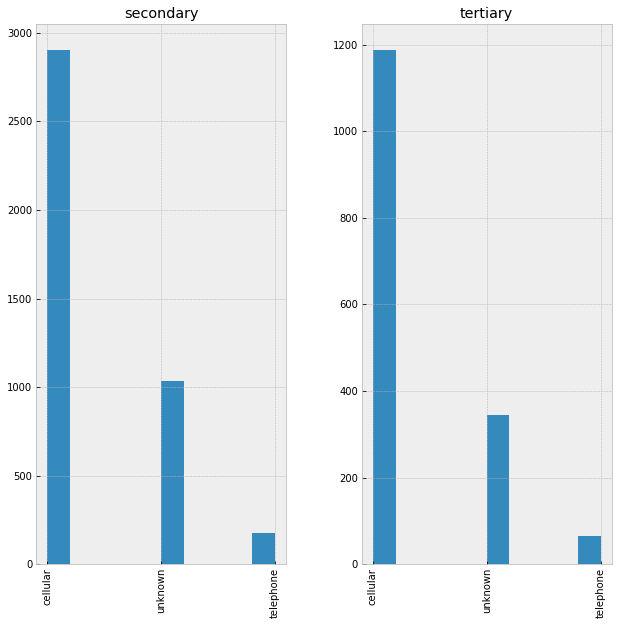

In [202]:
df_technician = train_df.loc[(train_df['job'] == 'technician')&((train_df['education'] == 'secondary')|(train_df['education'] == 'tertiary'))].copy()
for check in listcheck:
    splithist(df_technician, check, 'education')
    print(check)

housing
loan
default
age
balance
marital
contact


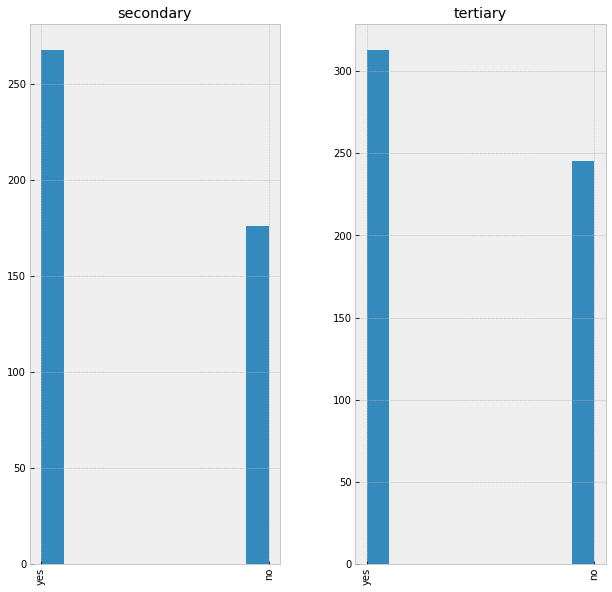

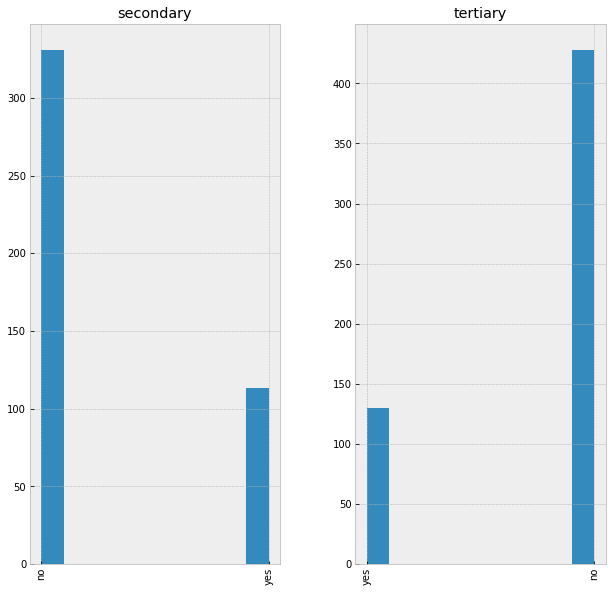

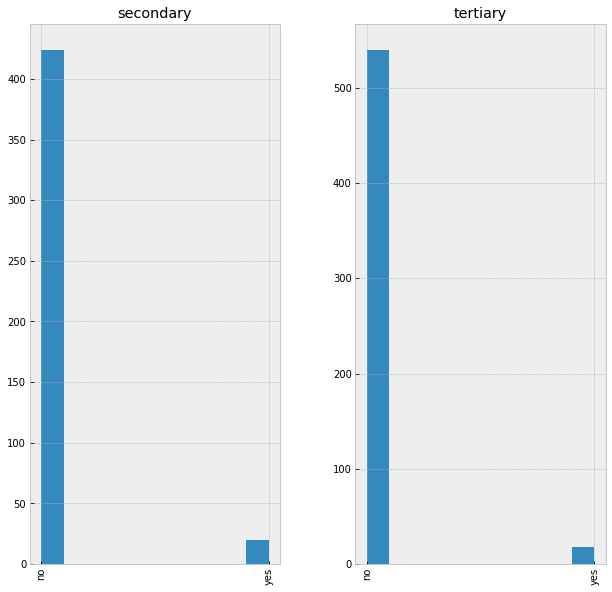

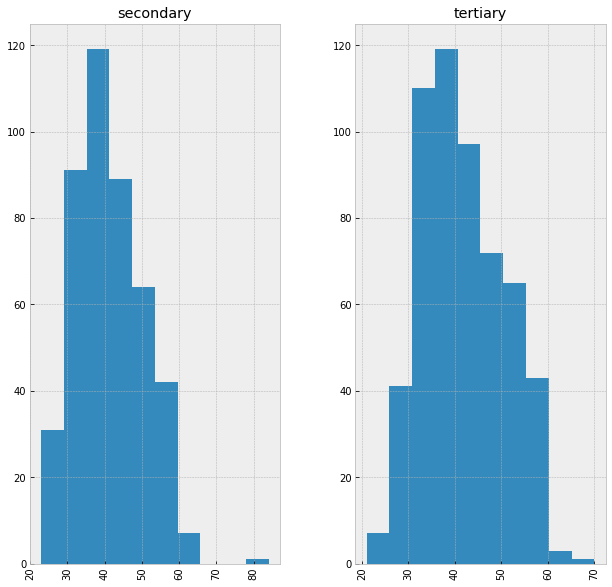

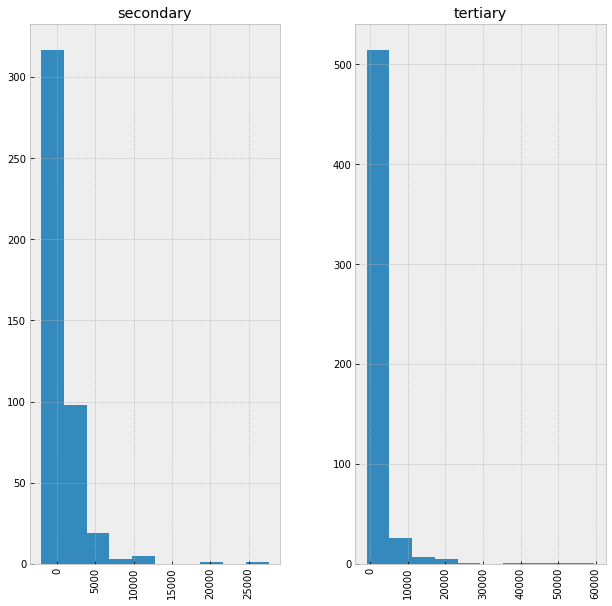

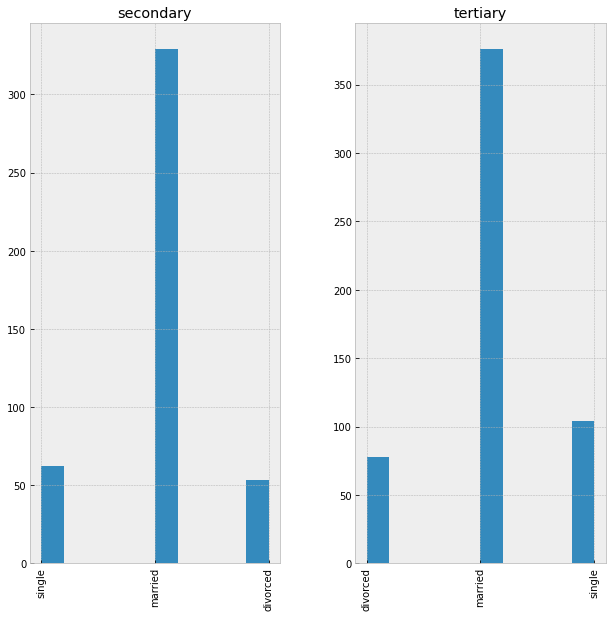

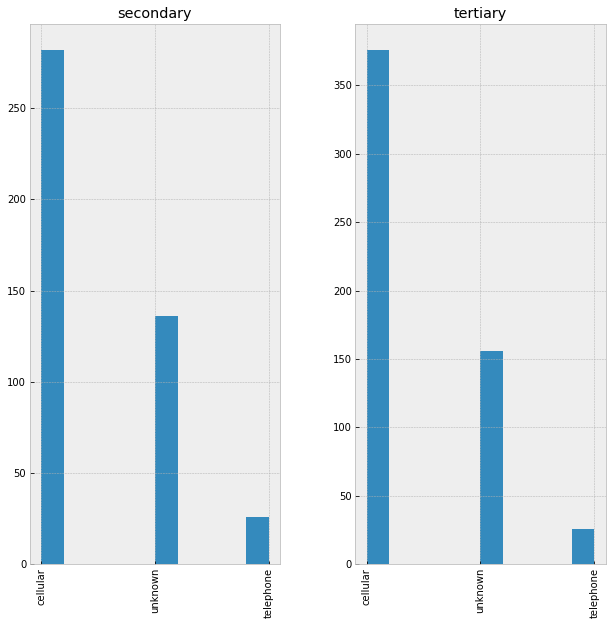

In [203]:
df_entrepreneur = train_df.loc[(train_df['job'] == 'entrepreneur')&((train_df['education'] == 'secondary')|(train_df['education'] == 'tertiary'))].copy()
for check in listcheck:
    splithist(df_entrepreneur, check, 'education')
    print(check)

### Use job, housing, loan, age, default, balance, marital, contact to predict education

There are no strong secondary predictors for education for the following jobs:

    blue-collar -> primary, secondary
    housemaid -> primary, secondary
    self-employed -> secondary, tertiary
    technician -> secondary, tertiary
    entrepreneur -> secondary, tertiary
    
    retired, student, unemployed, unknown
    
To try data imputation for education for the above groups, using housing, loan,default, age, balance, marital, contact, job

In [181]:
train_df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,42,technician,divorced,secondary,no,-78,yes,yes,cellular,29,jul,10,23,-1,0,unknown,no
1,50,management,married,tertiary,no,106,yes,no,unknown,15,may,388,2,-1,0,unknown,no
2,47,admin.,married,secondary,no,407,yes,no,unknown,5,jun,67,12,-1,0,unknown,no
3,39,admin.,divorced,secondary,no,952,yes,no,unknown,16,jun,62,1,-1,0,unknown,no
4,30,management,single,tertiary,no,364,no,no,cellular,30,apr,306,2,-1,0,unknown,yes


In [207]:
X = train_df[['job','marital','default', 'balance','housing','loan','contact']]
Y = train_df['education']

for feature in ['job','marital','default','housing','contact','loan']:
    X[feature]= preprocessing.LabelEncoder().fit_transform(X[feature])
cat_features = ['job','marital','default','housing','contact','loan']

encoded_features = []
for feature in cat_features:
    encoded_feat = preprocessing.OneHotEncoder().fit_transform(df_all[feature].values.reshape(-1,1)).toarray()
    n = df_all[feature].nunique()
    cols = ['{}_{}'.format(feature,n) for n in range(1, n+1)]
    encoded_df = pd.DataFrame(encoded_feat, columns = cols)
    encoded_df.index = df_all.index
    encoded_features.append(encoded_df)


In [208]:
X

,job,marital,default,balance,housing,loan,contact
0,9,0,0,-78,1,1,0
1,4,1,0,106,1,0,2
2,0,1,0,407,1,0,2
3,0,0,0,952,1,0,2
4,4,2,0,364,0,0,0
...,...,...,...,...,...,...,...
36163,4,2,0,1243,1,0,1
36164,1,1,0,171,1,0,2
36165,9,1,0,-274,1,0,2
36166,1,1,0,103,0,0,0


In [152]:
train_df.loc[(train_df['job'] == 'services')&(train_df['education'] == 'unknown')]

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
129,46,services,married,unknown,no,854,yes,no,cellular,3,apr,478,3,-1,0,unknown,no
295,43,services,divorced,unknown,no,-291,yes,no,cellular,11,may,277,1,301,2,failure,no
1132,32,services,single,unknown,no,6145,yes,no,cellular,14,may,362,1,287,13,failure,no
1549,38,services,married,unknown,no,10189,yes,no,cellular,18,jul,482,2,-1,0,unknown,no
1725,42,services,single,unknown,no,410,no,no,cellular,21,nov,34,2,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34427,33,services,single,unknown,no,523,yes,no,unknown,28,may,86,1,-1,0,unknown,yes
34687,51,services,married,unknown,no,3413,no,no,cellular,27,aug,146,7,-1,0,unknown,no
35226,38,services,divorced,unknown,no,6360,no,no,unknown,20,jun,1409,2,-1,0,unknown,yes
35496,43,services,single,unknown,no,0,no,no,unknown,5,may,73,1,-1,0,unknown,no


In [195]:
train_df.loc[(train_df['education'] == 'unknown')]

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
31,77,unknown,married,unknown,no,397,no,no,telephone,7,may,300,3,-1,0,unknown,yes
32,57,blue-collar,married,unknown,no,807,yes,no,unknown,6,may,211,2,-1,0,unknown,no
47,43,blue-collar,married,unknown,no,245,yes,no,cellular,16,apr,829,1,-1,0,unknown,no
51,52,technician,married,unknown,no,9687,yes,no,unknown,29,may,936,1,-1,0,unknown,no
101,59,blue-collar,divorced,unknown,no,124,yes,no,unknown,6,may,26,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35989,38,technician,married,unknown,no,573,yes,no,unknown,6,may,87,1,-1,0,unknown,no
36021,18,student,single,unknown,no,108,no,no,cellular,9,feb,92,1,183,1,success,yes
36061,54,blue-collar,married,unknown,no,1827,no,no,cellular,20,apr,167,1,350,1,failure,no
36105,42,blue-collar,married,unknown,no,1323,yes,no,unknown,19,may,19,1,-1,0,unknown,no
